In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import subprocess
import sys
import time

from astropy.table import Table
from astropy.io import fits

### Handy functions and globals

In [2]:
flux_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'
nnpz_dir = '/home/aalvarez/Work/Projects/NNPZ'
nnpz_bin = os.path.join(nnpz_dir, 'bin', 'nnpz')
nnpzphoto_bin = os.path.join(nnpz_dir, 'bin', 'NnpzBuildPhotometry')
reference_sample = '/home/aalvarez/Work/Data/dc3/ReferenceSample'
nnpz_env = os.environ.copy()
nnpz_env['PYTHONPATH'] = nnpz_env.get('PYTHONPATH', '') + ':' + nnpz_dir

output_dir = '/home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift'

In [3]:
flux_hdul = fits.open(flux_file)

In [4]:
nnpz_original_config_file = '/home/aalvarez/Work/Data/coupon/nnpz.conf'
target_catalog = '/home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits'
fluxes_file = '/home/aalvarez/Work/Data/coupon/fluxes.fits'

In [21]:
def extract_filter_set(original_dir, new_dir, filter_name, flux_hdul, hdu_name):
    shutil.rmtree(new_dir, ignore_errors=True)
    shutil.copytree(original_dir, new_dir)
    
    filter_ascii_file = os.path.join(new_dir, filter_shifted) + '.ascii'
    filter_hdu = flux_hdul[hdu_name]
    t = Table([filter_hdu.data['Wavelength'], filter_hdu.data['Transmission']], names=['col1', 'col2'])
    t.write(filter_ascii_file, format='ascii')

In [23]:
def compare_filters(original_dir, new_dir, filter_name):
    original = Table.read(os.path.join(original_dir, filter_name) + '.ascii', format='ascii')
    compared = Table.read(os.path.join(new_dir, filter_name) + '.ascii', format='ascii')
    plt.plot(original['col1'], original['col2'], label='Original')
    plt.plot(compared['col1'], compared['col2'], label='New')
    plt.legend()

In [61]:
def plot_filter(filter_dir, filter_name):
    content = Table.read(os.path.join(filter_dir, filter_name) + '.ascii', format='ascii')
    plt.plot(content['col1'], content['col2'], label=filter_name)
    plt.legend()

In [7]:
def rebuild_photometry(photometry_output, filters_dir):
    if os.path.exists(photometry_output):
        print(f"{photometry_output} already exists, so skipping run")
        return
        
    nnpzphoto_proc = subprocess.Popen([
        nnpzphoto_bin,
        '--sample-dir', reference_sample,
        '--filters', filters_dir,
        '--out-type', 'F_nu_uJy',
        '--out-file', photometry_output
    ], env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    while nnpzphoto_proc.poll() is None:
        print(nnpzphoto_proc.stdout.readline().decode('utf-8'), end='')

In [8]:
def run_nnpz(nnpz_bin, nnpz_config, nnpz_env):
    nnpz_config_file = '/tmp/nnpz_tests/nnpz.conf'
    if os.path.exists(nnpz_config_file):
        os.unlink(nnpz_config_file)

    if os.path.exists(nnpz_config['output_file']):
        print(f"{nnpz_config['output_file']} already exists, so skipping run")
        return 0
        
    with open(nnpz_config_file, mode='w') as fd:
        for key, value in nnpz_config.items():
            if not key.startswith('_'):
                if isinstance(value, str):
                    print(f'{key} = "{value}"', file=fd)
                else:
                    print(f'{key} = {value}', file=fd)

    start = time.monotonic()
    nnpz_proc = subprocess.Popen(
        [nnpz_bin, nnpz_config_file],
        env=nnpz_env, stdout=subprocess.PIPE, stderr=subprocess.STDOUT
    )
    while nnpz_proc.poll() is None:
        print(nnpz_proc.stdout.readline().decode('utf-8'), end='')
    end = time.monotonic()
    return end - start

In [9]:
def plot_matching(reference, target):
    max_count = reference['NeighborIDs'].shape[1]
    counts = np.zeros(max_count + 1) # One position per count (so 0 to as many neighbours in the reference)
    for r, t in zip(reference, target):
        c = np.isin(r['NeighborIDs'], t['NeighborIDs']).sum()
        counts[c] += 1
    plt.hist(range(max_count + 1), weights=counts, bins=max_count+1)
    return counts

In [10]:
def get_filter_shift(original, new):
    fluxes_hdul = fits.open(fluxes_file)
    original_hdu = fluxes_hdul[original]
    new_hdu = fluxes_hdul[new]
    original_mean = np.average(original_hdu.data['Wavelength'], weights=original_hdu.data['Transmission'])
    new_mean = np.average(new_hdu.data['Wavelength'], weights=new_hdu.data['Transmission'])
    return new_mean - original_mean

## Compare "real" neighbours when using shifts
See task [#16305](https://redmine.isdc.unige.ch/issues/16305?next_issue_id=16303).

Since we are going to compare the worst case (greatest mean wavelength shift),
we need to recompute the photometry for the reference sample with an `r` filter
thas has been shifted as well.

### Copy filter transmissions, use shifted 'r'

In [41]:
original_filters_dir = '/home/aalvarez/Work/Data/dc3/AuxiliaryData/Filters/Euclid'
filters_dir = '/tmp/nnpz_tests/Shift9Filters'

We create a copy of these filters, using the shifted `r`

In [58]:
extract_filter_set(original_filters_dir, filters_dir, 'r', flux_hdul, 'r_shift9')

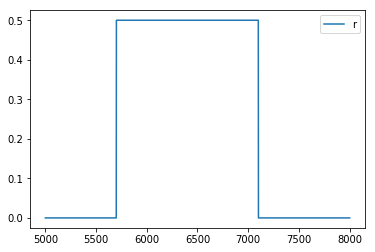

In [81]:
plot_filter(filters_dir, 'r')

### Recompute photometries for the reference sample using the shifted filter

In [59]:
r_shift_9_reference_photometry = '/tmp/nnpz_tests/Shift9ReferencePhotometry.fits'

In [60]:
rebuild_photometry(r_shift_9_reference_photometry, filters_dir)


Opening reference sample /home/aalvarez/Work/Data/dc3/ReferenceSample...
Successfully opened reference sample

Reading filter transmissions from /tmp/nnpz_tests/Shift9Filters...
    Y
    i
    J
    u
    r
    g
    z
    H
    vis
Successfully read filter transmissions

Computing photometry values...
    Photometry type: F_nu_uJy
    Progress: 0%
    Progress: 1%
    Progress: 2%
    Progress: 3%
    Progress: 4%
    Progress: 5%
    Progress: 6%
    Progress: 7%
    Progress: 8%
    Progress: 9%
    Progress: 10%
    Progress: 11%
    Progress: 12%
    Progress: 13%
    Progress: 14%
    Progress: 15%
    Progress: 16%
    Progress: 17%
    Progress: 18%
    Progress: 19%
    Progress: 20%
    Progress: 21%
    Progress: 22%
    Progress: 23%
    Progress: 24%
    Progress: 25%
    Progress: 26%
    Progress: 27%
    Progress: 28%
    Progress: 29%
    Progress: 30%
    Progress: 31%
    Progress: 32%
    Progress: 33%
    Progress: 34%
    Progress: 35%
    Progress: 36%
    Prog

### Find "real" neighbours
Ok, so we have re-computed the photometry shifting the filter `r` by 100, which is the maximum shift value on the catalog
generated by Coupon.

We need now to run NNPZ using *only* bruteforce ($\chi^2$ distance) to find the best 30 against `r_shift_9` (which is shifted by 100).

To make things easier, we patch an existing configuration file.

In [63]:
real_output_file = os.path.join(output_dir, 'Shift9Real.fits')

In [64]:
nnpz_config = {}
with open(nnpz_original_config_file) as fd:
    exec(fd.read(), nnpz_config)

In [68]:
nnpz_config['reference_sample_dir'] = reference_sample
nnpz_config['reference_sample_phot_file'] = r_shift_9_reference_photometry
nnpz_config['target_catalog'] = target_catalog
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_shift9_obs', 'r_shift9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['target_catalog_filters_mean'] = None
nnpz_config['input_size'] = 2000 # To be changed
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
nnpz_config['output_file'] = real_output_file
if 'pdz_mc_samples' in nnpz_config:
    del nnpz_config['pdz_mc_samples']

In [69]:
run_nnpz(nnpz_bin, nnpz_config, nnpz_env)

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Shift9Real.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Shift9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 2000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u', 'g', '

200.8839876219863

### Run now with the actual reference sample (not shifted)
We use the actual reference sample, without the shifted transmission, and classify the same target catalog (with the shifted field as well).
This time we use the KD-Tree implementation, and get 1000 neighbours, which should (hopefully) include the "real" neighbours we got from the previous step.

In [70]:
nnpz_config['reference_sample_phot_file'] = '/home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits'
nnpz_config['neighbor_method'] = 'KDTree'
nnpz_config['neighbors_no'] = 1000
euclidean_output_file = os.path.join(output_dir, 'Shift9Euclidean.fits')
nnpz_config['output_file'] = euclidean_output_file

In [71]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Shift9Euclidean.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 1000
    target_catalog_filters_mean : None
    batch_size : 2000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u',

### Compare euclidean neighbours with "real" neighbours
So, by now, we have in `euclidean_output_file` 1k neighbours in euclidean distance, and in `real_output_file` we have the
30 real neighbours.
We want to check how many of those 30 are in the euclidean output.

In [72]:
euclidean = Table.read(euclidean_output_file)
real = Table.read(real_output_file)

True


array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   2.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.00000000e+00,   2.00000000e+00,   0.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         3.00000000e+00,   2.00000000e+00,   3.00000000e+00,
         6.00000000e+00,   4.00000000e+00,   7.00000000e+00,
         1.30000000e+01,   9.00000000e+00,   1.00000000e+01,
         3.20000000e+01,   5.10000000e+01,   1.22000000e+02,
         1.72400000e+03])

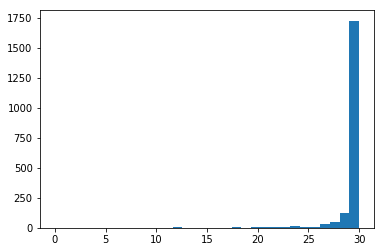

In [73]:
print(np.all(real['ID'] == euclidean['ID'])) # Just make sure the output is in the same order
plot_matching(real, euclidean)

Not bad at first sight.

### Compare combined neighbours with "real" neighbours
Pretty much same flow, but use the combined method, with 30 final neighbours, 1000 batch size.

In [74]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
combined_output_file = os.path.join(output_dir, 'Shift9Combined.fits')
nnpz_config['output_file'] = combined_output_file

In [75]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Shift9Combined.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_shift9_obs', 'r_shift9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u', 'g

In [76]:
combined = Table.read(combined_output_file)

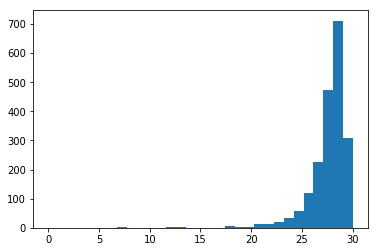

In [77]:
counts = plot_matching(real, combined)

In [78]:
counts[0]

0.0

## Same, but with skew
Let's use `r_skewing9`.

### Get "real" neighbours, using bruteforce and a recomputed photometry

In [79]:
r_skew_9_reference_photometry = '/tmp/nnpz_tests/Skew9ReferencePhotometry.fits'
skew9_filters_dir = '/tmp/nnpz_tests/Skew9Filters'

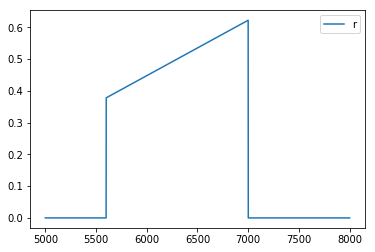

In [80]:
extract_filter_set(original_filters_dir, skew9_filters_dir, 'r', flux_hdul, 'r_skewing9')
plot_filter(skew9_filters_dir, 'r')

In [82]:
rebuild_photometry(r_skew_9_reference_photometry, skew9_filters_dir)


Opening reference sample /home/aalvarez/Work/Data/dc3/ReferenceSample...
Successfully opened reference sample

Reading filter transmissions from /tmp/nnpz_tests/Skew9Filters...
    Y
    i
    J
    u
    r
    g
    z
    H
    vis
Successfully read filter transmissions

Computing photometry values...
    Photometry type: F_nu_uJy
    Progress: 0%
    Progress: 1%
    Progress: 2%
    Progress: 3%
    Progress: 4%
    Progress: 5%
    Progress: 6%
    Progress: 7%
    Progress: 8%
    Progress: 9%
    Progress: 10%
    Progress: 11%
    Progress: 12%
    Progress: 13%
    Progress: 14%
    Progress: 15%
    Progress: 16%
    Progress: 17%
    Progress: 18%
    Progress: 19%
    Progress: 20%
    Progress: 21%
    Progress: 22%
    Progress: 23%
    Progress: 24%
    Progress: 25%
    Progress: 26%
    Progress: 27%
    Progress: 28%
    Progress: 29%
    Progress: 30%
    Progress: 31%
    Progress: 32%
    Progress: 33%
    Progress: 34%
    Progress: 35%
    Progress: 36%
    Progr

In [83]:
nnpz_config['target_catalog_filters'] = [
    ('u_obs', 'u_obs_err'),
    ('g_obs', 'g_obs_err'),
    ('r_skewing9_obs', 'r_skewing9_obs_err'),
    ('i_obs', 'i_obs_err'),
    ('z_obs', 'z_obs_err'),
    ('vis_obs', 'vis_obs_err'),
    ('Y_obs', 'Y_obs_err'),
    ('J_obs', 'J_obs_err'),
    ('H_obs', 'H_obs_err')
]
nnpz_config['reference_sample_phot_file'] = r_skew_9_reference_photometry
nnpz_config['neighbor_method'] = 'BruteForce'
nnpz_config['neighbors_no'] = 30
skew9_output_file = os.path.join(output_dir, 'Skew9Real.fits')
nnpz_config['output_file'] = skew9_output_file

In [84]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Skew9Real.fits
    copy_input_columns : True
    reference_sample_phot_file : /tmp/nnpz_tests/Skew9ReferencePhotometry.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_skewing9_obs', 'r_skewing9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u', 'g',

### Re-run, KD-Tree, but using the standard reference sample

In [85]:
nnpz_config['reference_sample_phot_file'] = '/home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits'
nnpz_config['neighbor_method'] = 'KDTree'
nnpz_config['neighbors_no'] = 1000
skew9_euclidean_output_file = os.path.join(output_dir, 'Skew9Euclidean.fits')
nnpz_config['output_file'] = skew9_euclidean_output_file

In [86]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Skew9Euclidean.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 1000
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_skewing9_obs', 'r_skewing9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['

In [87]:
skew9_real = Table.read(skew9_output_file)
skew9_euclidean = Table.read(skew9_euclidean_output_file)

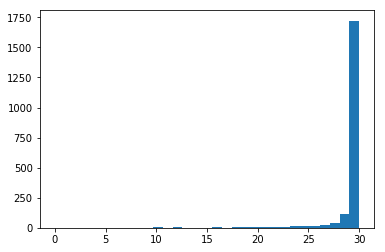

In [88]:
counts = plot_matching(skew9_real, skew9_euclidean)

In [89]:
counts[0]

0.0

### Skew, Combined

In [90]:
nnpz_config['neighbor_method'] = 'Combined'
nnpz_config['batch_size'] = 1000
nnpz_config['neighbors_no'] = 30
skew9_combined_output_file = os.path.join(output_dir, 'Skew9Combined.fits')
nnpz_config['output_file'] = skew9_combined_output_file

In [91]:
duration = run_nnpz(nnpz_bin, nnpz_config, nnpz_env)
print(f"Took {duration} seconds")

Configuration file: /tmp/nnpz_tests/nnpz.conf
Running NNPZ with the following options:
    target_transmission_provider : shifted
    log_level : DEBUG
    output_file : /home/aalvarez/Work/Data/coupon/ComparativeMethods_Shift/Skew9Combined.fits
    copy_input_columns : True
    reference_sample_phot_file : /home/aalvarez/Work/Data/dc3/dc3_F_nu_uJy.fits
    weight_method : Likelihood
    input_size : 2000
    flags_in_separate_columns : True
    reference_sample_dir : /home/aalvarez/Work/Data/dc3/ReferenceSample
    neighbors_no : 30
    target_catalog_filters_mean : None
    batch_size : 1000
    target_catalog_filters : [('u_obs', 'u_obs_err'), ('g_obs', 'g_obs_err'), ('r_skewing9_obs', 'r_skewing9_obs_err'), ('i_obs', 'i_obs_err'), ('z_obs', 'z_obs_err'), ('vis_obs', 'vis_obs_err'), ('Y_obs', 'Y_obs_err'), ('J_obs', 'J_obs_err'), ('H_obs', 'H_obs_err')]
    target_catalog : /home/aalvarez/Work/Data/coupon/fluxes_COSMOS15_test_with_means.fits
    reference_sample_phot_filters : ['u',

In [92]:
skew9_combined = Table.read(skew9_combined_output_file)

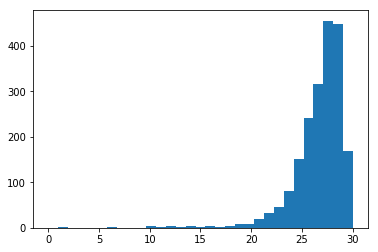

In [93]:
counts = plot_matching(skew9_real, skew9_combined)

In [94]:
counts[0]

0.0